In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
### YOUR CODE HERE
from tensorflow.keras import regularizers
###
import tensorflow.keras.utils as ku 
import numpy as np
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt


--2020-08-13 16:41:41--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.214.128, 173.194.216.128, 172.217.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.214.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2020-08-13 16:41:41 (125 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [2]:
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")
print(corpus[:3])

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1
print("total words:",total_words)

['from fairest creatures we desire increase,', "that thereby beauty's rose might never die,", 'but as the riper should by time decease,']
total words: 3211


In [4]:
#Create input sequences using list of tokens
input_sequences = []
for line in corpus:
  token_list = tokenizer.texts_to_sequences([line])[0]
  for i in range(1, len(token_list)):
    n_gram_sequence = token_list[:i+1]
    input_sequences.append(n_gram_sequence)

# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

#https://keras.io/api/utils/python_utils/#to_categorical-function
label = tf.keras.utils.to_categorical(label, num_classes=total_words)

In [5]:
print(label[0])
print(len(label[0]))
print(total_words)

[0. 0. 0. ... 0. 0. 0.]
3211
3211


In [6]:
model = Sequential()
model.add(Embedding(input_dim=total_words, output_dim=100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))

my_optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=my_optimizer, metrics=['accuracy'])

print(model.summary())


history = model.fit(predictors, label, epochs=100, verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 100)           321100    
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 300)           301200    
_________________________________________________________________
dropout (Dropout)            (None, 10, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1605)              162105    
_________________________________________________________________
dense_1 (Dense)              (None, 3211)              5156866   
Total params: 6,101,671
Trainable params: 6,101,671
Non-trainable params: 0
______________________________________________

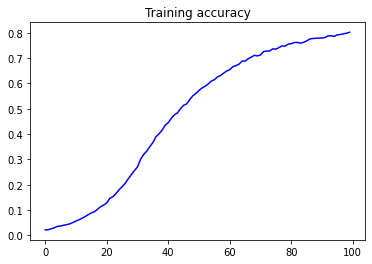

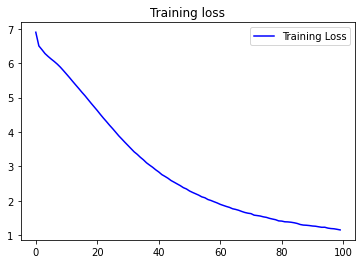

In [7]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')
plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()
plt.show()

In [8]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Help me Obi Wan Kenobi, you're my only hope did mercy be go up back untold come twain dead green grow me much rage might conspire find arising dote each friend rage might dearer grow hate smell thing love's friend doth this lie to me bright not have hell in thee say write heaven might do true foes exceed lie to be change so true true bright dear love to meetness heaven forbid thee so behold live as bright false still leaves deceive blot me conscience have down for thee on thee dear friend of woe sight away bring me ' to go forth write to thee in thee
